## 03-Activation functions & Optimizers

[1.Sigmoid](#1)
  - [1-1.Zero Center](#1-1)
  - [1-2.Vanishing Gradient](#1-2)  


[2.Tanh](#2)  


[3.ReLU](#3)  

[4.Stochastic Gradient Descent](#4)
  - [4-1.Load Dataset](#4-1)
  - [4-2.Forward & Backward with Mini-Batch](#4-2)

[5.SGD+Momentum](#5)

[6.Adagrad](#6)

[7.RMSProp](#7)

[8.Adam](#8)
  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from utils.data_utils import download_and_extract_mnist_data

<a id="1"></a>
## 1.Sigmoid

$$
\text{Sigmoid}(x) = \sigma(x) = \frac{1}{1 + e^{-x}}
$$


- 시그모이드 함수는 입력된 값을 0과 1 사이값으로 변환하는 비선형 함수.
- Saturated Region이 존재해 Gradient가 소실될 수 있다.
- non-zero centered function.

In [2]:
# Sigmoid 함수와 그 미분
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))


<a id="1-1"></a>
### 1-1.Non zero center

출력값의 중심이 0이 아닌 0.5

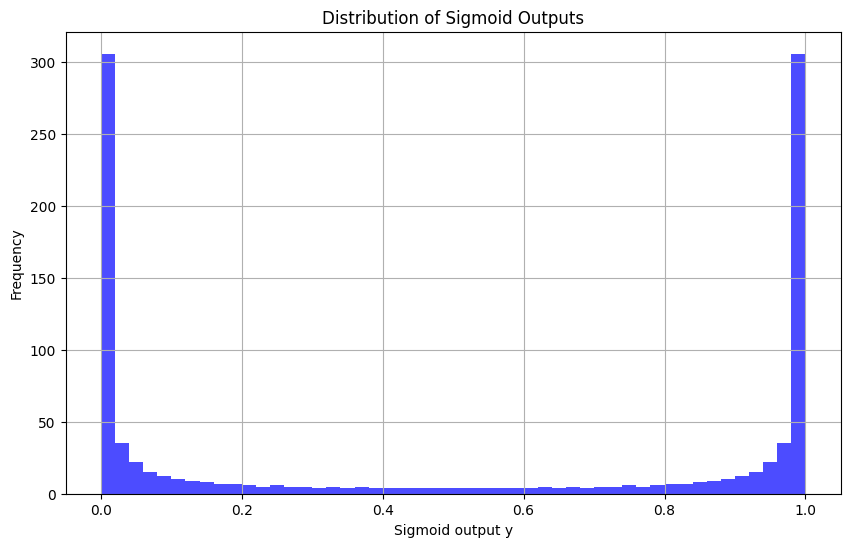

In [3]:
x = np.linspace(-10, 10, 1000) # -10부터 10까지 1000개의 값
y = sigmoid(x) # Sigmoid 함수를 사용하여 출력 데이터 계산

# y값의 분포를 히스토그램으로 시각화
plt.figure(figsize=(10, 6))
plt.hist(y, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Sigmoid Outputs')
plt.xlabel('Sigmoid output y')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

<a id="1-2"></a>
### 1-2.Vanishing gradients

간단한 NN을 제작하는데, 이해를 돕기 위해 코드라인에 대한 설명을 첨부한다.
1. `SimpleNeuralNetwork` 클래스는 `input_size`, `layer_depths`, `layer_widths`를 인자로 받는다. -> 데이터 샘플이 가진 feature 수, NN의 layer 수, 각각의 layer가 갖는 unit의 수.
2. line5 ~ line 11는 N개의 layer들에 대한 정의로 각각의 layer가 갖는 weight matrix를 생성해 weights 리스트에 모두 담는다.
3. 

In [4]:
# 로지스틱 회귀 모델을 위한 간단한 신경망 클래스
class SimpleNeuralNetwork:
    def __init__(self, input_size, layer_depths, layer_widths):
        self.layers = layer_depths
        self.weights = [np.random.randn(input_size, layer_widths[0])] ## first hidden layer

        for i in range(self.layers - 1): ## second ~ nth hidden layers
            weight = np.random.randn(layer_widths[i], layer_widths[i+1])
            self.weights.append(weight)

        self.weights += [np.random.randn(layer_widths[i], 1)] ## output layer

    def print_weights(self):
        for idx, weight in enumerate(self.weights):
            print(f"layer {idx} : {weight.shape}")

    def forward(self, X):
        activations = [X]
        for i in range(self.layers):
            net = np.dot(activations[-1], self.weights[i])
            activations.append(sigmoid(net))

        return activations

    def compute_gradients(self, X, y):
        activations = self.forward(X)
        output = activations[-1]
        errors = [output - y] ## loss
        
        # 역전파: 그래디언트 계산
        gradients = []
        for i in reversed(range(self.layers)):
            delta = errors[-1] * sigmoid_derivative(activations[i+1]) ## dL/d(hat y)  * da/dz
            gradients.append(np.dot(activations[i].T, delta)) ## dL/dz * dz/dw = dL/dz * x^T
            if i != 0:
                errors.append(np.dot(delta, self.weights[i].T))
        gradients = gradients[::-1]
        
        return gradients

In [5]:
X = np.random.randn(10, 3) + 100
y = np.random.randint(0, 2, (10, 1))

In [6]:
layer_depths = 200
layer_widths = [100 for _ in range(layer_depths)]
nn = SimpleNeuralNetwork(input_size=3, layer_depths=layer_depths, layer_widths=layer_widths)

# print(nn.print_weights())

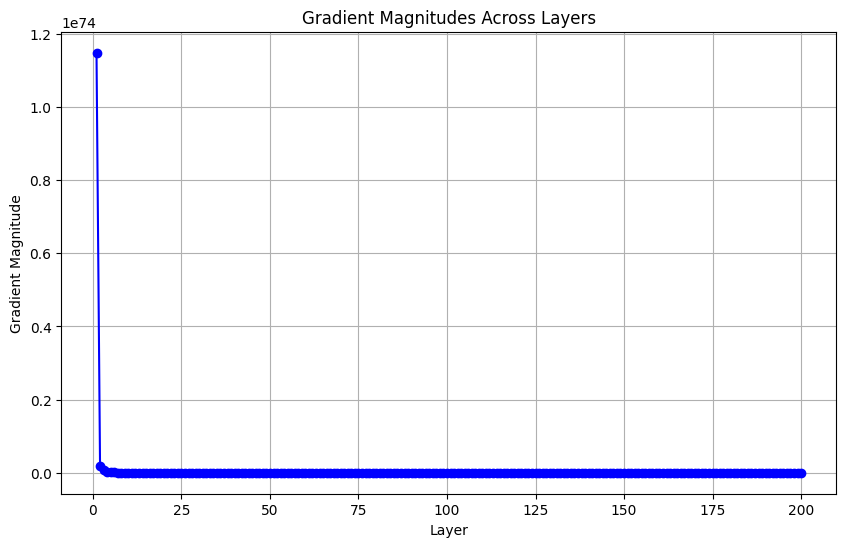

In [7]:
gradients = nn.compute_gradients(X, y)
gradients_magnitudes = [np.linalg.norm(grad) for grad in gradients] ## Gradient는 partial derivative matrix이기 때문에, 행렬에 대한 크기를 계산해서 layer_depths개의 스칼라로 만들어야 한다.

layers = range(1, layer_depths + 1)
plt.figure(figsize=(10, 6))
plt.plot(layers, gradients_magnitudes, marker='o', linestyle='-', color='b')
plt.title('Gradient Magnitudes Across Layers')
plt.xlabel('Layer')
plt.ylabel('Gradient Magnitude')
plt.grid(True)
plt.show()

<a id="2"></a>
## Tanh
$$ \tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} $$

- zero center function
- sigmoid와 마찬가지로 saturated region 존재.

In [8]:
def tanh(x):
    head = np.exp(x) - np.exp(-x)
    tail = np.exp(x) + np.exp(-x)

    return head / tail

tanh 함수의 출력값(함수값)에 대한 그래프를 그려보면, 0을 중심축으로 값들이 분포되어 있는 것을 확인할 수 있다.

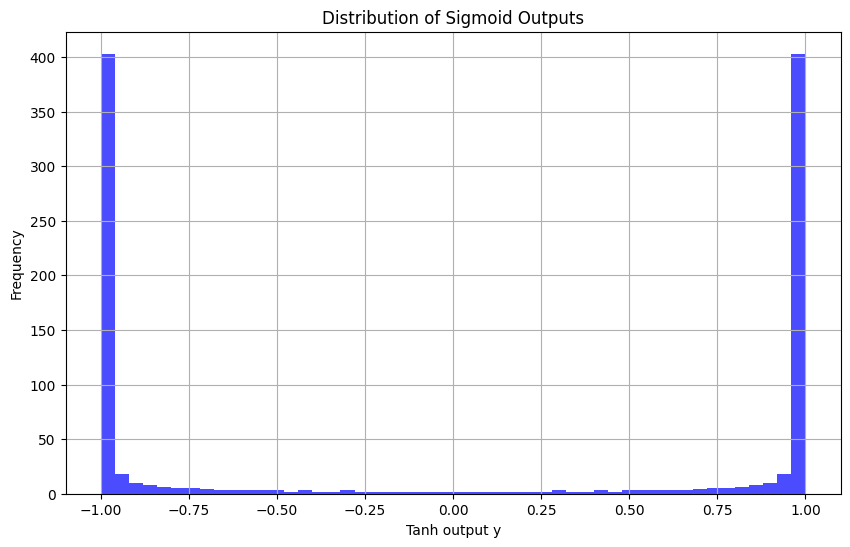

In [9]:
x = np.linspace(-10, 10, 1000)
y = tanh(x)

plt.figure(figsize=(10, 6))
plt.hist(y, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Sigmoid Outputs')
plt.xlabel('Tanh output y')
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

<a id="3"></a>
## ReLU

$$ \text{ReLU}(x) = max(0, z)$$
$$
\text{ReLU}'(x) = 
\begin{cases} 
0, & \text{if } x < 0 \\
1, & \text{if } x \geq 0 
\end{cases}
$$


- 입력값이 0보다 작을 때는 0으로 출력. -> saturated region
- 1이상의 입력값은 입력값을 그대로 출력한다.(Linearity) -> non saturated region

In [10]:
def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)


In [11]:
class SimpleNeuralNetwork:
    def __init__(self, input_size, layer_depths, layer_widths):
        self.layers = layer_depths
        self.weights = [np.random.randn(input_size, layer_widths[0])] ## first hidden layer

        for i in range(self.layers - 1): ## second ~ nth hidden layers
            weight = np.random.randn(layer_widths[i], layer_widths[i+1])
            self.weights.append(weight)

        self.weights += [np.random.randn(layer_widths[i], 1)] ## output layer

    def print_weights(self):
        for idx, weight in enumerate(self.weights):
            print(f"layer {idx} : {weight.shape}")

    def forward(self, X):
        activations = [X]
        for i in range(self.layers):
            net = np.dot(activations[-1], self.weights[i])
            activations.append(relu(net)) ## sigmoid -> relu

        return activations

    def compute_gradients(self, X, y):
        activations = self.forward(X)
        output = activations[-1]
        errors = [output - y] ## loss
        
        # 역전파: 그래디언트 계산
        gradients = []
        for i in reversed(range(self.layers)):
            delta = errors[-1] * relu_derivative(activations[i+1]) ## dL/d(hat y)  * da/dz
            gradients.append(np.dot(activations[i].T, delta)) ## dL/dz * dz/dw = dL/dz * x^T
            if i != 0:
                errors.append(np.dot(delta, self.weights[i].T))
        gradients = gradients[::-1]
        
        return gradients

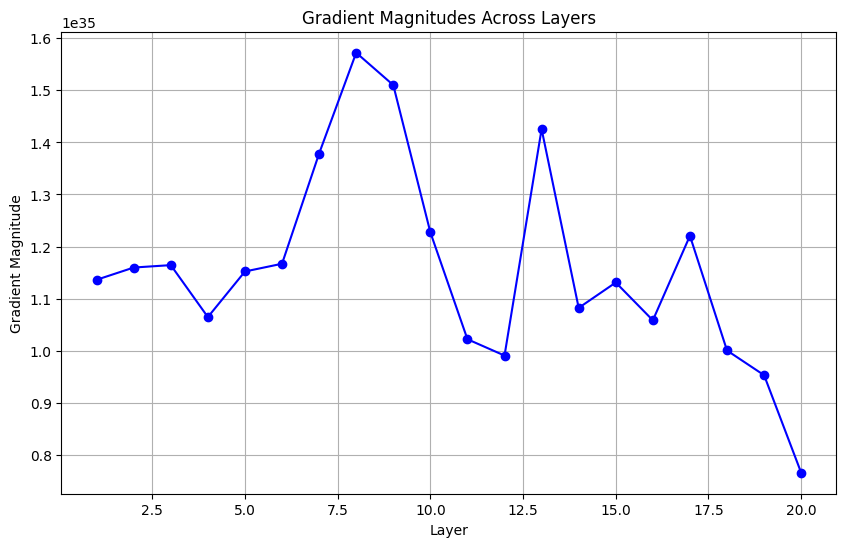

In [12]:
X = np.random.randn(10, 3)
y = np.random.randint(0, 2, (10, 1))

layer_depths = 20
layer_widths = [100 for _ in range(layer_depths)]
nn = SimpleNeuralNetwork(input_size=3, layer_depths=layer_depths, layer_widths=layer_widths)

# print(nn.print_weights())

gradients = nn.compute_gradients(X, y)
gradients_magnitudes = [np.linalg.norm(grad) for grad in gradients]

layers = range(1, layer_depths + 1)
plt.figure(figsize=(10, 6))
plt.plot(layers, gradients_magnitudes, marker='o', linestyle='-', color='b')
plt.title('Gradient Magnitudes Across Layers')
plt.xlabel('Layer')
plt.ylabel('Gradient Magnitude')
plt.grid(True)
plt.show()

<a id="4"></a>
## 4.Stochastic Gradient Descent

<a id="4-1"></a>
### 4-1.Load Dataset

In [13]:
data_dir = "/home/pervinco/Datasets/MNIST"

train_x, train_y, test_x, test_y = download_and_extract_mnist_data(data_dir)
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

train_x = train_x.reshape(train_x.shape[0], -1).T
test_x = test_x.reshape(test_x.shape[0], -1).T
print(train_x.shape, test_x.shape)

train_y = np.where(train_y == 7, 1, 0)
test_y = np.where(test_y == 7, 1, 0)

train_y = np.expand_dims(train_y, axis=0)
test_y = np.expand_dims(test_y, axis=0)
print(train_y.shape, test_y.shape)

MNIST data is already downloaded and extracted.
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
(784, 60000) (784, 10000)
(1, 60000) (1, 10000)


In [14]:
classes = np.unique(train_y)
print(classes)

[0 1]


<a id="4-2"></a>
### 4-2.Forward & Backward with Mini-Batch

In [15]:
epochs = 100
batch_size = 64
learning_rate = 0.2

train_x = train_x / 255.0
test_x = test_x / 255.0

In [16]:
depth = 3
unit_list = [512] * depth

In [17]:
def linear_layer(input_dim, output_dim):
    weights = np.random.randn(output_dim, input_dim) * 0.01  # 가중치 초기화, 형태 조정
    bias = np.zeros((output_dim, 1))  # 편향 초기화
    return {'weights': weights, 'bias': bias}

layers = []
input_dim = train_x.shape[0]  # 첫 번째 층의 입력 차원
for idx in range(depth):
    if idx == 0:
        output_dim = unit_list[idx]
    else:
        output_dim = unit_list[idx] if idx < depth - 1 else len(classes)
    layers.append(linear_layer(input_dim, output_dim))
    input_dim = output_dim  # 다음 층의 입력 차원을 현재 층의 출력 차원으로 업데이트


In [18]:
def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred + 1e-9)) / len(y_true)

    return loss


def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z))
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)


def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    bce = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    return bce

In [19]:
def forward_propagation(X, layers):
    activations = [X]  # 입력층의 활성화 결과는 입력 데이터 X.
    for layer in layers:
        W = layer['weights']
        b = layer['bias']
        Z = np.dot(W, activations[-1]) + b
        A = sigmoid(Z)
        # if layer is not layers[-1]:  # 출력층이 아닌 경우 소프트맥스 활성화 함수 적용
        #     A = relu(Z)
        # else:  # 출력층인 경우 소프트맥스 활성화 함수 적용
        #     A = softmax(Z)
        activations.append(A)

    return activations


In [20]:
def backward_propagation(X, Y, activations, layers, learning_rate):
    m = X.shape[1]  # 배치 내의 샘플 수
    gradients = []
    
    # 출력층에서의 오차 계산
    dA = activations[-1] - Y
    for i in reversed(range(len(layers))):
        A_prev = activations[i]
        Z = np.dot(layers[i]['weights'], A_prev) + layers[i]['bias']
        dZ = dA * sigmoid_derivative(Z)
        
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        if i > 0:
            dA = np.dot(layers[i]['weights'].T, dZ)
        
        # 가중치와 편향 업데이트
        layers[i]['weights'] -= learning_rate * dW
        layers[i]['bias'] -= learning_rate * db
        gradients.append((dW, db))
    
    return layers, gradients


In [21]:
def train_network(X_train, Y_train, layers, learning_rate, epochs, batch_size):
    num_samples = X_train.shape[1]
    num_batches = num_samples // batch_size

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_train[:, start_idx:end_idx]
            Y_batch = Y_train[:, start_idx:end_idx]

            # 순전파
            activations = forward_propagation(X_batch, layers)

            # 역전파 및 가중치 업데이트
            layers, gradients = backward_propagation(X_batch, Y_batch, activations, layers, learning_rate)

            # 배치 손실 계산 (교차 엔트로피 손실 함수 사용)
            loss = binary_cross_entropy(Y_batch, activations[-1])
            epoch_loss += loss

        # 에포크별 평균 손실 출력
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

In [22]:
train_network(train_x, train_y, layers, learning_rate, epochs, batch_size)

Epoch 1/100, Loss: 30.4958


Epoch 2/100, Loss: 30.4332


Epoch 3/100, Loss: 30.3911


Epoch 4/100, Loss: 30.3192


Epoch 5/100, Loss: 30.1738


Epoch 6/100, Loss: 29.8038


Epoch 7/100, Loss: 28.3693


Epoch 8/100, Loss: 17.0395


Epoch 9/100, Loss: 6.1496


Epoch 10/100, Loss: 5.1510


Epoch 11/100, Loss: 4.8421


Epoch 12/100, Loss: 4.6830


Epoch 13/100, Loss: 4.5856


Epoch 14/100, Loss: 4.5208


Epoch 15/100, Loss: 4.4761


Epoch 16/100, Loss: 4.4449


Epoch 17/100, Loss: 4.4233


Epoch 18/100, Loss: 4.4087


Epoch 19/100, Loss: 4.3994


Epoch 20/100, Loss: 4.3940


Epoch 21/100, Loss: 4.3916


Epoch 22/100, Loss: 4.3916


Epoch 23/100, Loss: 4.3934


Epoch 24/100, Loss: 4.3966


Epoch 25/100, Loss: 4.4008


Epoch 26/100, Loss: 4.4057


Epoch 27/100, Loss: 4.4113


Epoch 28/100, Loss: 4.4173


Epoch 29/100, Loss: 4.4238


Epoch 30/100, Loss: 4.4305


Epoch 31/100, Loss: 4.4375


Epoch 32/100, Loss: 4.4447


Epoch 33/100, Loss: 4.4520


Epoch 34/100, Loss: 4.4596


Epoch 35/100, Loss: 4.4674


Epoch 36/100, Loss: 4.4752


Epoch 37/100, Loss: 4.4833


Epoch 38/100, Loss: 4.4914


Epoch 39/100, Loss: 4.4997


Epoch 40/100, Loss: 4.5081


Epoch 41/100, Loss: 4.5166


Epoch 42/100, Loss: 4.5252


Epoch 43/100, Loss: 4.5339


Epoch 44/100, Loss: 4.5428


Epoch 45/100, Loss: 4.5518


Epoch 46/100, Loss: 4.5608


Epoch 47/100, Loss: 4.5700


Epoch 48/100, Loss: 4.5793


Epoch 49/100, Loss: 4.5887


Epoch 50/100, Loss: 4.5981


Epoch 51/100, Loss: 4.6077


Epoch 52/100, Loss: 4.6173


Epoch 53/100, Loss: 4.6270


Epoch 54/100, Loss: 4.6368


Epoch 55/100, Loss: 4.6467


Epoch 56/100, Loss: 4.6566


Epoch 57/100, Loss: 4.6665


Epoch 58/100, Loss: 4.6765


Epoch 59/100, Loss: 4.6865


Epoch 60/100, Loss: 4.6965


Epoch 61/100, Loss: 4.7066


Epoch 62/100, Loss: 4.7167


Epoch 63/100, Loss: 4.7267


Epoch 64/100, Loss: 4.7368


Epoch 65/100, Loss: 4.7468


Epoch 66/100, Loss: 4.7568


Epoch 67/100, Loss: 4.7668


Epoch 68/100, Loss: 4.7768


Epoch 69/100, Loss: 4.7867


Epoch 70/100, Loss: 4.7966


Epoch 71/100, Loss: 4.8064


Epoch 72/100, Loss: 4.8162


Epoch 73/100, Loss: 4.8260


Epoch 74/100, Loss: 4.8357


Epoch 75/100, Loss: 4.8453


Epoch 76/100, Loss: 4.8549


Epoch 77/100, Loss: 4.8644


Epoch 78/100, Loss: 4.8738


Epoch 79/100, Loss: 4.8832


Epoch 80/100, Loss: 4.8924


Epoch 81/100, Loss: 4.9017


Epoch 82/100, Loss: 4.9108


Epoch 83/100, Loss: 4.9199


Epoch 84/100, Loss: 4.9289


Epoch 85/100, Loss: 4.9378


Epoch 86/100, Loss: 4.9466


Epoch 87/100, Loss: 4.9554


Epoch 88/100, Loss: 4.9640


Epoch 89/100, Loss: 4.9726


Epoch 90/100, Loss: 4.9811


Epoch 91/100, Loss: 4.9895


Epoch 92/100, Loss: 4.9979


Epoch 93/100, Loss: 5.0061


Epoch 94/100, Loss: 5.0143


Epoch 95/100, Loss: 5.0224


Epoch 96/100, Loss: 5.0304


Epoch 97/100, Loss: 5.0383


Epoch 98/100, Loss: 5.0461


Epoch 99/100, Loss: 5.0538


Epoch 100/100, Loss: 5.0615


<a id="#5"></a>
## 5. SGD + Momentum

In [23]:
def backward_propagation_with_momentum(X, Y, activations, layers, learning_rate, momentum=0.9):
    m = X.shape[1]  # 배치 내의 샘플 수
    gradients = []
    # 모멘텀을 위한 속도 초기화
    v_dW = [np.zeros_like(layer['weights']) for layer in layers]
    v_db = [np.zeros_like(layer['bias']) for layer in layers]
    
    # 출력층에서의 오차 계산
    dA = activations[-1] - Y
    for i in reversed(range(len(layers))):
        A_prev = activations[i]
        Z = np.dot(layers[i]['weights'], A_prev) + layers[i]['bias']
        dZ = dA * sigmoid_derivative(Z)
        
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        if i > 0:
            dA = np.dot(layers[i]['weights'].T, dZ)
        
        # 모멘텀을 사용한 가중치와 편향 업데이트
        v_dW[i] = momentum * v_dW[i] + (1 - momentum) * dW
        v_db[i] = momentum * v_db[i] + (1 - momentum) * db
        layers[i]['weights'] -= learning_rate * v_dW[i]
        layers[i]['bias'] -= learning_rate * v_db[i]
        gradients.append((dW, db))
    
    return layers, gradients

In [24]:
def train_network(X_train, Y_train, layers, learning_rate, epochs, batch_size):
    num_samples = X_train.shape[1]
    num_batches = num_samples // batch_size

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_train[:, start_idx:end_idx]
            Y_batch = Y_train[:, start_idx:end_idx]

            # 순전파
            activations = forward_propagation(X_batch, layers)

            # 역전파 및 가중치 업데이트
            layers, gradients = backward_propagation_with_momentum(X_batch, Y_batch, activations, layers, learning_rate)

            # 배치 손실 계산 (교차 엔트로피 손실 함수 사용)
            loss = cross_entropy_loss(Y_batch, activations[-1])
            epoch_loss += loss

        # 에포크별 평균 손실 출력
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

In [25]:
train_network(train_x, train_y, layers, learning_rate, epochs, batch_size)

Epoch 1/100, Loss: 5.1064


Epoch 2/100, Loss: 4.9961


Epoch 3/100, Loss: 4.9947


Epoch 4/100, Loss: 4.9934


Epoch 5/100, Loss: 4.9922


Epoch 6/100, Loss: 4.9910


Epoch 7/100, Loss: 4.9898


Epoch 8/100, Loss: 4.9886


Epoch 9/100, Loss: 4.9874


Epoch 10/100, Loss: 4.9863


Epoch 11/100, Loss: 4.9852


Epoch 12/100, Loss: 4.9842


Epoch 13/100, Loss: 4.9832


Epoch 14/100, Loss: 4.9823


Epoch 15/100, Loss: 4.9814


Epoch 16/100, Loss: 4.9805


Epoch 17/100, Loss: 4.9797


Epoch 18/100, Loss: 4.9790


Epoch 19/100, Loss: 4.9782


Epoch 20/100, Loss: 4.9776


Epoch 21/100, Loss: 4.9769


Epoch 22/100, Loss: 4.9763


Epoch 23/100, Loss: 4.9757


Epoch 24/100, Loss: 4.9752


Epoch 25/100, Loss: 4.9747


Epoch 26/100, Loss: 4.9742


Epoch 27/100, Loss: 4.9738


Epoch 28/100, Loss: 4.9733


Epoch 29/100, Loss: 4.9729


Epoch 30/100, Loss: 4.9726


Epoch 31/100, Loss: 4.9722


Epoch 32/100, Loss: 4.9719


Epoch 33/100, Loss: 4.9716


Epoch 34/100, Loss: 4.9713


Epoch 35/100, Loss: 4.9710


Epoch 36/100, Loss: 4.9708


Epoch 37/100, Loss: 4.9706


Epoch 38/100, Loss: 4.9703


Epoch 39/100, Loss: 4.9701


Epoch 40/100, Loss: 4.9700


Epoch 41/100, Loss: 4.9698


Epoch 42/100, Loss: 4.9696


Epoch 43/100, Loss: 4.9695


Epoch 44/100, Loss: 4.9694


Epoch 45/100, Loss: 4.9692


Epoch 46/100, Loss: 4.9691


Epoch 47/100, Loss: 4.9690


Epoch 48/100, Loss: 4.9690


Epoch 49/100, Loss: 4.9689


Epoch 50/100, Loss: 4.9688


Epoch 51/100, Loss: 4.9688


Epoch 52/100, Loss: 4.9687


Epoch 53/100, Loss: 4.9687


Epoch 54/100, Loss: 4.9687


Epoch 55/100, Loss: 4.9687


Epoch 56/100, Loss: 4.9687


Epoch 57/100, Loss: 4.9687


Epoch 58/100, Loss: 4.9687


Epoch 59/100, Loss: 4.9687


Epoch 60/100, Loss: 4.9687


Epoch 61/100, Loss: 4.9687


Epoch 62/100, Loss: 4.9688


Epoch 63/100, Loss: 4.9688


Epoch 64/100, Loss: 4.9689


Epoch 65/100, Loss: 4.9689


Epoch 66/100, Loss: 4.9690


Epoch 67/100, Loss: 4.9691


Epoch 68/100, Loss: 4.9691


Epoch 69/100, Loss: 4.9692


Epoch 70/100, Loss: 4.9693


Epoch 71/100, Loss: 4.9694


Epoch 72/100, Loss: 4.9695


Epoch 73/100, Loss: 4.9696


Epoch 74/100, Loss: 4.9697


Epoch 75/100, Loss: 4.9698


Epoch 76/100, Loss: 4.9700


Epoch 77/100, Loss: 4.9701


Epoch 78/100, Loss: 4.9702


Epoch 79/100, Loss: 4.9704


Epoch 80/100, Loss: 4.9705


Epoch 81/100, Loss: 4.9706


Epoch 82/100, Loss: 4.9708


Epoch 83/100, Loss: 4.9710


Epoch 84/100, Loss: 4.9711


Epoch 85/100, Loss: 4.9713


Epoch 86/100, Loss: 4.9714


Epoch 87/100, Loss: 4.9716


Epoch 88/100, Loss: 4.9718


Epoch 89/100, Loss: 4.9720


Epoch 90/100, Loss: 4.9721


Epoch 91/100, Loss: 4.9723


Epoch 92/100, Loss: 4.9725


Epoch 93/100, Loss: 4.9727


Epoch 94/100, Loss: 4.9729


Epoch 95/100, Loss: 4.9731


Epoch 96/100, Loss: 4.9733


Epoch 97/100, Loss: 4.9735


Epoch 98/100, Loss: 4.9737


Epoch 99/100, Loss: 4.9740


Epoch 100/100, Loss: 4.9742


## 6.Adagrad

In [26]:
def backward_propagation_with_adagrad(X, Y, activations, layers, learning_rate, epsilon=1e-8):
    m = X.shape[1]  # 배치 내의 샘플 수
    gradients = []
    # Adagrad를 위한 기울기 제곱 누적 변수 초기화
    accum_grad_w = [np.zeros_like(layer['weights']) for layer in layers]
    accum_grad_b = [np.zeros_like(layer['bias']) for layer in layers]
    
    # 출력층에서의 오차 계산
    dA = activations[-1] - Y
    for i in reversed(range(len(layers))):
        A_prev = activations[i]
        Z = np.dot(layers[i]['weights'], A_prev) + layers[i]['bias']
        dZ = dA * sigmoid_derivative(Z)
        
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        if i > 0:
            dA = np.dot(layers[i]['weights'].T, dZ)
        
        # Adagrad 업데이트 규칙 적용
        accum_grad_w[i] += np.square(dW)
        accum_grad_b[i] += np.square(db)
        
        # 업데이트에 Adagrad 적용
        adjusted_lr_w = learning_rate / (np.sqrt(accum_grad_w[i]) + epsilon)
        adjusted_lr_b = learning_rate / (np.sqrt(accum_grad_b[i]) + epsilon)
        
        layers[i]['weights'] -= adjusted_lr_w * dW
        layers[i]['bias'] -= adjusted_lr_b * db
        gradients.append((dW, db))
    
    return layers, gradients

In [27]:
def train_network(X_train, Y_train, layers, learning_rate, epochs, batch_size):
    num_samples = X_train.shape[1]
    num_batches = num_samples // batch_size

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_train[:, start_idx:end_idx]
            Y_batch = Y_train[:, start_idx:end_idx]

            # 순전파
            activations = forward_propagation(X_batch, layers)

            # 역전파 및 가중치 업데이트
            layers, gradients = backward_propagation_with_adagrad(X_batch, Y_batch, activations, layers, learning_rate)

            # 배치 손실 계산 (교차 엔트로피 손실 함수 사용)
            loss = cross_entropy_loss(Y_batch, activations[-1])
            epoch_loss += loss

        # 에포크별 평균 손실 출력
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

In [28]:
train_network(train_x, train_y, layers, learning_rate, epochs, batch_size)

Epoch 1/100, Loss: 276.8122


Epoch 2/100, Loss: 277.0327


Epoch 3/100, Loss: 277.0327


Epoch 4/100, Loss: 277.0327


Epoch 5/100, Loss: 277.0327


Epoch 6/100, Loss: 277.0327


Epoch 7/100, Loss: 277.0327


Epoch 8/100, Loss: 277.0327


Epoch 9/100, Loss: 277.0327


Epoch 10/100, Loss: 277.0327


Epoch 11/100, Loss: 277.0327


Epoch 12/100, Loss: 277.0327


Epoch 13/100, Loss: 277.0327


Epoch 14/100, Loss: 277.0327


Epoch 15/100, Loss: 277.0327


Epoch 16/100, Loss: 277.0327


Epoch 17/100, Loss: 277.0327


Epoch 18/100, Loss: 277.0327


Epoch 19/100, Loss: 277.0327


Epoch 20/100, Loss: 277.0327


Epoch 21/100, Loss: 277.0327


Epoch 22/100, Loss: 277.0327


Epoch 23/100, Loss: 277.0327


Epoch 24/100, Loss: 277.0327


Epoch 25/100, Loss: 277.0327


Epoch 26/100, Loss: 277.0327


Epoch 27/100, Loss: 277.0327


Epoch 28/100, Loss: 277.0327


Epoch 29/100, Loss: 277.0327


Epoch 30/100, Loss: 277.0327


Epoch 31/100, Loss: 277.0327


Epoch 32/100, Loss: 277.0327


Epoch 33/100, Loss: 277.0327


Epoch 34/100, Loss: 277.0327


Epoch 35/100, Loss: 277.0327


Epoch 36/100, Loss: 277.0327


Epoch 37/100, Loss: 277.0327


Epoch 38/100, Loss: 277.0327


Epoch 39/100, Loss: 277.0327


Epoch 40/100, Loss: 277.0327


Epoch 41/100, Loss: 277.0327


Epoch 42/100, Loss: 277.0327


Epoch 43/100, Loss: 277.0327


Epoch 44/100, Loss: 277.0327


Epoch 45/100, Loss: 277.0327


Epoch 46/100, Loss: 277.0327


Epoch 47/100, Loss: 277.0327


Epoch 48/100, Loss: 277.0327


Epoch 49/100, Loss: 277.0327


Epoch 50/100, Loss: 277.0327


Epoch 51/100, Loss: 277.0327


Epoch 52/100, Loss: 277.0327


Epoch 53/100, Loss: 277.0327


Epoch 54/100, Loss: 277.0327


Epoch 55/100, Loss: 277.0327


Epoch 56/100, Loss: 277.0327


Epoch 57/100, Loss: 277.0327


Epoch 58/100, Loss: 277.0327


Epoch 59/100, Loss: 277.0327


Epoch 60/100, Loss: 277.0327


Epoch 61/100, Loss: 277.0327


Epoch 62/100, Loss: 277.0327


Epoch 63/100, Loss: 277.0327


Epoch 64/100, Loss: 277.0327


Epoch 65/100, Loss: 277.0327


Epoch 66/100, Loss: 277.0327


Epoch 67/100, Loss: 277.0327


Epoch 68/100, Loss: 277.0327


Epoch 69/100, Loss: 277.0327


Epoch 70/100, Loss: 277.0327


Epoch 71/100, Loss: 277.0327


Epoch 72/100, Loss: 277.0327


Epoch 73/100, Loss: 277.0327


Epoch 74/100, Loss: 277.0327


Epoch 75/100, Loss: 277.0327


Epoch 76/100, Loss: 277.0327


Epoch 77/100, Loss: 277.0327


Epoch 78/100, Loss: 277.0327


Epoch 79/100, Loss: 277.0327


Epoch 80/100, Loss: 277.0327


Epoch 81/100, Loss: 277.0327


Epoch 82/100, Loss: 277.0327


Epoch 83/100, Loss: 277.0327


Epoch 84/100, Loss: 277.0327


Epoch 85/100, Loss: 277.0327


Epoch 86/100, Loss: 277.0327


Epoch 87/100, Loss: 277.0327


Epoch 88/100, Loss: 277.0327


Epoch 89/100, Loss: 277.0327


Epoch 90/100, Loss: 277.0327


Epoch 91/100, Loss: 277.0327


Epoch 92/100, Loss: 277.0327


Epoch 93/100, Loss: 277.0327


Epoch 94/100, Loss: 277.0327


Epoch 95/100, Loss: 277.0327


Epoch 96/100, Loss: 277.0327


Epoch 97/100, Loss: 277.0327


Epoch 98/100, Loss: 277.0327


Epoch 99/100, Loss: 277.0327


Epoch 100/100, Loss: 277.0327


## 7.RMSProp

In [29]:
def backward_propagation_with_RMSProp(X, Y, activations, layers, learning_rate, beta=0.9, epsilon=1e-8):
    m = X.shape[1]  # 배치 내의 샘플 수
    gradients = []
    # RMSProp를 위한 가중치와 편향의 기울기 제곱의 지수적 평균 변수 초기화
    s_dW = [np.zeros_like(layer['weights']) for layer in layers]
    s_db = [np.zeros_like(layer['bias']) for layer in layers]
    
    # 출력층에서의 오차 계산
    dA = activations[-1] - Y
    for i in reversed(range(len(layers))):
        A_prev = activations[i]
        Z = np.dot(layers[i]['weights'], A_prev) + layers[i]['bias']
        dZ = dA * sigmoid_derivative(Z)
        
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        if i > 0:
            dA = np.dot(layers[i]['weights'].T, dZ)
        
        # RMSProp 업데이트 규칙 적용
        s_dW[i] = beta * s_dW[i] + (1 - beta) * np.square(dW)
        s_db[i] = beta * s_db[i] + (1 - beta) * np.square(db)
        
        # 가중치와 편향 업데이트
        layers[i]['weights'] -= learning_rate * dW / (np.sqrt(s_dW[i]) + epsilon)
        layers[i]['bias'] -= learning_rate * db / (np.sqrt(s_db[i]) + epsilon)
        gradients.append((dW, db))
    
    return layers, gradients


In [30]:
def train_network(X_train, Y_train, layers, learning_rate, epochs, batch_size):
    num_samples = X_train.shape[1]
    num_batches = num_samples // batch_size

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_train[:, start_idx:end_idx]
            Y_batch = Y_train[:, start_idx:end_idx]

            # 순전파
            activations = forward_propagation(X_batch, layers)

            # 역전파 및 가중치 업데이트
            layers, gradients = backward_propagation_with_RMSProp(X_batch, Y_batch, activations, layers, learning_rate)

            # 배치 손실 계산 (교차 엔트로피 손실 함수 사용)
            loss = cross_entropy_loss(Y_batch, activations[-1])
            epoch_loss += loss

        # 에포크별 평균 손실 출력
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

In [31]:
train_network(train_x, train_y, layers, learning_rate, epochs, batch_size)

Epoch 1/100, Loss: 277.0327


Epoch 2/100, Loss: 277.0327


Epoch 3/100, Loss: 277.0327


Epoch 4/100, Loss: 277.0327


Epoch 5/100, Loss: 277.0327


Epoch 6/100, Loss: 277.0327


Epoch 7/100, Loss: 277.0327


Epoch 8/100, Loss: 277.0327


Epoch 9/100, Loss: 277.0327


Epoch 10/100, Loss: 277.0327


Epoch 11/100, Loss: 277.0327


Epoch 12/100, Loss: 277.0327


Epoch 13/100, Loss: 277.0327


Epoch 14/100, Loss: 277.0327


Epoch 15/100, Loss: 277.0327


Epoch 16/100, Loss: 277.0327


Epoch 17/100, Loss: 277.0327


Epoch 18/100, Loss: 277.0327


Epoch 19/100, Loss: 277.0327


Epoch 20/100, Loss: 277.0327


Epoch 21/100, Loss: 277.0327


Epoch 22/100, Loss: 277.0327


Epoch 23/100, Loss: 277.0327


Epoch 24/100, Loss: 277.0327


Epoch 25/100, Loss: 277.0327


Epoch 26/100, Loss: 277.0327


Epoch 27/100, Loss: 277.0327


Epoch 28/100, Loss: 277.0327


Epoch 29/100, Loss: 277.0327


Epoch 30/100, Loss: 277.0327


Epoch 31/100, Loss: 277.0327


Epoch 32/100, Loss: 277.0327


Epoch 33/100, Loss: 277.0327


Epoch 34/100, Loss: 277.0327


Epoch 35/100, Loss: 277.0327


Epoch 36/100, Loss: 277.0327


Epoch 37/100, Loss: 277.0327


Epoch 38/100, Loss: 277.0327


Epoch 39/100, Loss: 277.0327


Epoch 40/100, Loss: 277.0327


Epoch 41/100, Loss: 277.0327


Epoch 42/100, Loss: 277.0327


Epoch 43/100, Loss: 277.0327


Epoch 44/100, Loss: 277.0327


Epoch 45/100, Loss: 277.0327


Epoch 46/100, Loss: 277.0327


Epoch 47/100, Loss: 277.0327


Epoch 48/100, Loss: 277.0327


Epoch 49/100, Loss: 277.0327


Epoch 50/100, Loss: 277.0327


Epoch 51/100, Loss: 277.0327


Epoch 52/100, Loss: 277.0327


Epoch 53/100, Loss: 277.0327


Epoch 54/100, Loss: 277.0327


Epoch 55/100, Loss: 277.0327


Epoch 56/100, Loss: 277.0327


Epoch 57/100, Loss: 277.0327


Epoch 58/100, Loss: 277.0327


Epoch 59/100, Loss: 277.0327


Epoch 60/100, Loss: 277.0327


Epoch 61/100, Loss: 277.0327


Epoch 62/100, Loss: 277.0327


Epoch 63/100, Loss: 277.0327


Epoch 64/100, Loss: 277.0327


Epoch 65/100, Loss: 277.0327


Epoch 66/100, Loss: 277.0327


Epoch 67/100, Loss: 277.0327


Epoch 68/100, Loss: 277.0327


Epoch 69/100, Loss: 277.0327


Epoch 70/100, Loss: 277.0327


Epoch 71/100, Loss: 277.0327


Epoch 72/100, Loss: 277.0327


Epoch 73/100, Loss: 277.0327


Epoch 74/100, Loss: 277.0327


Epoch 75/100, Loss: 277.0327


Epoch 76/100, Loss: 277.0327


Epoch 77/100, Loss: 277.0327


Epoch 78/100, Loss: 277.0327


Epoch 79/100, Loss: 277.0327


Epoch 80/100, Loss: 277.0327


Epoch 81/100, Loss: 277.0327


Epoch 82/100, Loss: 277.0327


Epoch 83/100, Loss: 277.0327


Epoch 84/100, Loss: 277.0327


Epoch 85/100, Loss: 277.0327


Epoch 86/100, Loss: 277.0327


Epoch 87/100, Loss: 277.0327


Epoch 88/100, Loss: 277.0327


Epoch 89/100, Loss: 277.0327


Epoch 90/100, Loss: 277.0327


Epoch 91/100, Loss: 277.0327


Epoch 92/100, Loss: 277.0327


Epoch 93/100, Loss: 277.0327


Epoch 94/100, Loss: 277.0327


Epoch 95/100, Loss: 277.0327


Epoch 96/100, Loss: 277.0327


Epoch 97/100, Loss: 277.0327


Epoch 98/100, Loss: 277.0327


Epoch 99/100, Loss: 277.0327


Epoch 100/100, Loss: 277.0327


## 8.Adam

In [32]:
def initialize_adam(layers):
    """
    Adam 알고리즘에 필요한 변수를 초기화합니다.
    """
    v = [np.zeros_like(layer['weights']) for layer in layers]
    s = [np.zeros_like(layer['weights']) for layer in layers]
    
    v_bias = [np.zeros_like(layer['bias']) for layer in layers]
    s_bias = [np.zeros_like(layer['bias']) for layer in layers]
    
    return v, s, v_bias, s_bias

def backward_propagation_with_adam(X, Y, activations, layers, learning_rate, v, s, v_bias, s_bias, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
    m = X.shape[1]  # 배치 내의 샘플 수
    gradients = []
    t += 1  # 업데이트 횟수 증가
    
    # 출력층에서의 오차 계산
    dA = activations[-1] - Y
    for i in reversed(range(len(layers))):
        A_prev = activations[i]
        Z = np.dot(layers[i]['weights'], A_prev) + layers[i]['bias']
        dZ = dA * sigmoid_derivative(Z)
        
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        if i > 0:
            dA = np.dot(layers[i]['weights'].T, dZ)
        
        # 모멘텀 업데이트 (v)
        v[i] = beta1 * v[i] + (1 - beta1) * dW
        v_bias[i] = beta1 * v_bias[i] + (1 - beta1) * db
        
        # RMSprop 업데이트 (s)
        s[i] = beta2 * s[i] + (1 - beta2) * np.square(dW)
        s_bias[i] = beta2 * s_bias[i] + (1 - beta2) * np.square(db)
        
        # 바이어스 보정 적용
        v_corrected = v[i] / (1 - np.power(beta1, t))
        s_corrected = s[i] / (1 - np.power(beta2, t))
        v_bias_corrected = v_bias[i] / (1 - np.power(beta1, t))
        s_bias_corrected = s_bias[i] / (1 - np.power(beta2, t))
        
        # 매개변수 업데이트
        layers[i]['weights'] -= learning_rate * v_corrected / (np.sqrt(s_corrected) + epsilon)
        layers[i]['bias'] -= learning_rate * v_bias_corrected / (np.sqrt(s_bias_corrected) + epsilon)
        gradients.append((dW, db))
    
    return layers, gradients, v, s, v_bias, s_bias, t


In [33]:
def train_network(X_train, Y_train, layers, learning_rate, epochs, batch_size):
    num_samples = X_train.shape[1]
    num_batches = num_samples // batch_size

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx in tqdm(range(num_batches), desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            X_batch = X_train[:, start_idx:end_idx]
            Y_batch = Y_train[:, start_idx:end_idx]

            # 순전파
            activations = forward_propagation(X_batch, layers)

            # 역전파 및 가중치 업데이트
            layers, gradients = backward_propagation_with_adagrad(X_batch, Y_batch, activations, layers, learning_rate)

            # 배치 손실 계산 (교차 엔트로피 손실 함수 사용)
            loss = cross_entropy_loss(Y_batch, activations[-1])
            epoch_loss += loss

        # 에포크별 평균 손실 출력
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

In [34]:
train_network(train_x, train_y, layers, learning_rate, epochs, batch_size)

Epoch 1/100, Loss: 277.0327


Epoch 2/100, Loss: 277.0327


Epoch 3/100, Loss: 277.0327


Epoch 4/100, Loss: 277.0327


Epoch 5/100, Loss: 277.0327


Epoch 6/100, Loss: 277.0327


Epoch 7/100, Loss: 277.0327


Epoch 8/100, Loss: 277.0327


Epoch 9/100, Loss: 277.0327


Epoch 10/100, Loss: 277.0327


Epoch 11/100, Loss: 277.0327


Epoch 12/100, Loss: 277.0327


Epoch 13/100, Loss: 277.0327


Epoch 14/100, Loss: 277.0327


Epoch 15/100, Loss: 277.0327


Epoch 16/100, Loss: 277.0327


Epoch 17/100, Loss: 277.0327


Epoch 18/100, Loss: 277.0327


Epoch 19/100, Loss: 277.0327


Epoch 20/100, Loss: 277.0327


Epoch 21/100, Loss: 277.0327


Epoch 22/100, Loss: 277.0327


Epoch 23/100, Loss: 277.0327


Epoch 24/100, Loss: 277.0327


Epoch 25/100, Loss: 277.0327


Epoch 26/100, Loss: 277.0327


Epoch 27/100, Loss: 277.0327


Epoch 28/100, Loss: 277.0327


Epoch 29/100, Loss: 277.0327


Epoch 30/100, Loss: 277.0327


Epoch 31/100, Loss: 277.0327


Epoch 32/100, Loss: 277.0327


Epoch 33/100, Loss: 277.0327


Epoch 34/100, Loss: 277.0327


Epoch 35/100, Loss: 277.0327


Epoch 36/100, Loss: 277.0327


Epoch 37/100, Loss: 277.0327


Epoch 38/100, Loss: 277.0327


Epoch 39/100, Loss: 277.0327


Epoch 40/100, Loss: 277.0327


Epoch 41/100, Loss: 277.0327


Epoch 42/100, Loss: 277.0327


Epoch 43/100, Loss: 277.0327


Epoch 44/100, Loss: 277.0327


Epoch 45/100, Loss: 277.0327


Epoch 46/100, Loss: 277.0327


Epoch 47/100, Loss: 277.0327


Epoch 48/100, Loss: 277.0327


Epoch 49/100, Loss: 277.0327


Epoch 50/100, Loss: 277.0327


Epoch 51/100, Loss: 277.0327


Epoch 52/100, Loss: 277.0327


Epoch 53/100, Loss: 277.0327


Epoch 54/100, Loss: 277.0327


Epoch 55/100, Loss: 277.0327


Epoch 56/100, Loss: 277.0327


Epoch 57/100, Loss: 277.0327


Epoch 58/100, Loss: 277.0327


Epoch 59/100, Loss: 277.0327


Epoch 60/100, Loss: 277.0327


Epoch 61/100, Loss: 277.0327


Epoch 62/100, Loss: 277.0327


Epoch 63/100, Loss: 277.0327


Epoch 64/100, Loss: 277.0327


Epoch 65/100, Loss: 277.0327


Epoch 66/100, Loss: 277.0327


Epoch 67/100, Loss: 277.0327


Epoch 68/100, Loss: 277.0327


Epoch 69/100, Loss: 277.0327


Epoch 70/100, Loss: 277.0327


Epoch 71/100, Loss: 277.0327


Epoch 72/100, Loss: 277.0327


Epoch 73/100, Loss: 277.0327


Epoch 74/100, Loss: 277.0327


Epoch 75/100, Loss: 277.0327


Epoch 76/100, Loss: 277.0327


Epoch 77/100, Loss: 277.0327


Epoch 78/100, Loss: 277.0327


Epoch 79/100, Loss: 277.0327


Epoch 80/100, Loss: 277.0327


Epoch 81/100, Loss: 277.0327


Epoch 82/100, Loss: 277.0327


Epoch 83/100, Loss: 277.0327


Epoch 84/100, Loss: 277.0327


Epoch 85/100, Loss: 277.0327


Epoch 86/100, Loss: 277.0327


Epoch 87/100, Loss: 277.0327


Epoch 88/100, Loss: 277.0327


Epoch 89/100, Loss: 277.0327


Epoch 90/100, Loss: 277.0327


Epoch 91/100, Loss: 277.0327


Epoch 92/100, Loss: 277.0327


Epoch 93/100, Loss: 277.0327


Epoch 94/100, Loss: 277.0327


Epoch 95/100, Loss: 277.0327


Epoch 96/100, Loss: 277.0327


Epoch 97/100, Loss: 277.0327


Epoch 98/100, Loss: 277.0327


Epoch 99/100, Loss: 277.0327


Epoch 100/100, Loss: 277.0327
